In [2]:
import random
import numpy as np
import keras
from keras import ops
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import my_utility as mu
from keras.optimizers.schedules import ExponentialDecay
import keras.ops as K
from keras.losses import MeanSquaredError
from scipy.spatial.distance import cityblock


# Setup

In [2]:
tf.config.run_functions_eagerly(True)

# Parametri della rete
epochs = 10
batch_size = 16
margin = 1  # Margin for contrastive loss.

n = 384 # Dimensione codifica frattale

# Parametri del dataset
num_samples_train = 8000
num_samples_val = 2000
num_samples_test = 2000


# Inizializzazione
target_distances = np.zeros(num_samples_train)
val_target_distances=np.zeros(num_samples_val)

# Path cartelle dei file
dir_codify = r'.\img_celeba_10000'
dir_images_train = dir_codify + r'\img_celeba_10000_train'
dir_images_val = dir_codify + r'\img_celeba_10000_valid'
dir_image_test = dir_codify + r'\img_celeba_2000_test'

# Path di immagini ed embeddings
train_embeddings = mu.open_csv(dir_codify, '\codify_celeba_10000_train.csv', num_samples_train)
val_embeddings = mu.open_csv(dir_codify, '\codify_celeba_10000_valid.csv', num_samples_val)
test_embeddings = mu.open_csv(dir_codify, '\codify_celeba_2000_test.csv', num_samples_test)
train_images = mu.image_loader(dir_images_train)
val_images = mu.image_loader(dir_images_val)
test_images = mu.image_loader(dir_image_test)

(8000, 128, 128)
<class 'numpy.ndarray'>
(2000, 128, 128)
<class 'numpy.ndarray'>
(2000, 128, 128)
<class 'numpy.ndarray'>


# Network architecture

In [ ]:

# Definizione degli input della siamese
input_image = keras.layers.Input((128, 128, 1))
input_embedding = keras.layers.Input((384,))

# Ramo CNN della siamese per l'immagine
x = keras.layers.BatchNormalization()(input_image)
x = keras.layers.Conv2D(4, (5, 5), activation = "tanh")(x)
x = keras.layers.AveragePooling2D(pool_size = (2, 2))(x)
x = keras.layers.Conv2D(16, (5, 5), activation = "tanh")(x)
x = keras.layers.AveragePooling2D(pool_size = (2, 2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(n, activation = "tanh")(x)
embedding_network = keras.Model(input_image, x)

# Chiamo la rete che genera l'embedding sull'immagine in input
tower_image = embedding_network(input_image)

#### Euclidean distance

In [ ]:
# Merge dell'Embedding generato dalla CNN con l'embedding in input
merge_layer = keras.layers.Lambda(mu.euclidean_distance, output_shape = (1,))(
    [tower_image, input_embedding]
)

#### Manhattan distance

In [3]:

# Merge dell'Embedding generato dalla CNN con l'embedding in input
merge_layer = keras.layers.Lambda(mu.manhattan_distance, output_shape = (1,))(
    [tower_image, input_embedding]
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_1        │ (None, 384)       │  5,223,036 │ input_layer[0][0] │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 384)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional_1[0][… │
│                     │                   │            │ input_layer_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,223,036 (19.92 MB)

 Trainable params: 5,196,122 (19.82 MB)

 Non-trainable params: 26,914 (105.13 KB)

In [ ]:
# Merge layer
siamese = keras.Model(inputs=[input_image, input_embedding], outputs=merge_layer)

# Learning rate personalizzato (opzionale)
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps = 10000, decay_rate = 0.9, staircase=True
)

optimizer = keras.optimizers.Adam(learning_rate = 0.01)

# Chiamata alla loss personalizzata in my utility
siamese.compile(optimizer=optimizer, loss=mu.loss(margin = margin))

# Chiamata ad una loss di keras
#siamese.compile(optimizer=optimizer, loss=MeanSquaredError)
siamese.summary()

# Data conversion

In [4]:
# Verifica e conversione dei dati per la rete
train_images = np.array(train_images, dtype = np.float32)
train_embeddings = np.array(train_embeddings, dtype = np.float32)

val_images = np.array(val_images, dtype = np.float32)
val_embeddings = np.array(val_embeddings, dtype = np.float32)

test_images = np.array(val_images, dtype = np.float32)
test_embeddings = np.array(val_embeddings, dtype = np.float32)

# Assicurati che le etichette abbiano la stessa lunghezza del numero di campioni di addestramento
assert len(train_embeddings) == num_samples_train, "Errore: Lunghezza delle etichette non corrispondente al numero di campioni di addestramento."

# Training

In [5]:
# Addestramento
history = siamese.fit([train_images, train_embeddings], train_embeddings, epochs = epochs, batch_size = batch_size,
                      validation_data=([val_images, val_embeddings], val_embeddings))

c:\Users\antho\Progetto-FVAB\.conda\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 149s 296ms/step - loss: 16985777766400.0000 - val_loss: -23637161672704.0000
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 150s 299ms/step - loss: 9257828220928.0000 - val_loss: -23637744680960.0000
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 5232176136192.0000 - val_loss: -23638455615488.0000
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 283ms/step - loss: 7569036804096.0000 - val_loss: -23638765993984.0000
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 148s 296ms/step - loss: 3343666905088.0000 - val_loss: -23638965223424.0000
Epoch 6/10
394/500 ━━━━━━━━━━━━━━━━━━━━ 28s 273ms/step - loss: 542458773504.0000

KeyboardInterrupt: 

# Saving model

In [ ]:
siamese.save("my_model.keras", overwrite=True)

# Network evaluation

In [ ]:
# Valutazione della rete
eval_result = siamese.evaluate([test_images, test_embeddings], test_embeddings)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: -27128793923584.0000


## Loss function for a test example

#### Euclidean distance

In [ ]:

# Calcolo della distanza Euclidea per un esempio di test
example_index = 0
test_image = np.expand_dims(test_images[example_index], axis = 0)
test_embedding = np.expand_dims(test_embeddings[example_index], axis = 0)
predicted_embedding = siamese.predict([test_image, test_embedding])

# Calcolo della distanza Euclidea in numpy
euclidean_distance = np.linalg.norm(test_embedding - predicted_embedding)
print(f"Distanza Euclidea per l'immagine di test: {euclidean_distance}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
Distanza Euclidea per l'immagine di test: 720350.75


#### Manhattan distance

In [ ]:
# Calcolo della distanza di Manhattan per un esempio di test
example_index = 0
test_image = np.expand_dims(test_images[example_index], axis = 0)
test_embedding = np.expand_dims(test_embeddings[example_index], axis = 0)
predicted_embedding = siamese.predict([test_image, test_embedding])

# Calcolo della distanza di Manhattan
manhattan_dist = cityblock(test_embedding, predicted_embedding)
print(f"Distanza di Manhattan per l'immagine di test: {manhattan_dist}")

## Training and Validation loss

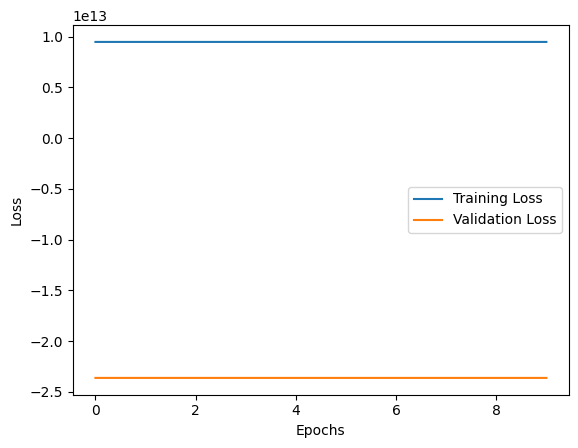

In [ ]:
# Visualizzazione della curva di apprendimento
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()